
#### Preparing data
Run the next cells to download and prepare the datasets and util functions

In [0]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [0]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [14]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

mkdir: cannot create directory ‘./local/datasets/’: File exists
--2020-04-28 02:26:48--  https://docs.google.com/uc?export=download&confirm=OK7c&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf
Resolving docs.google.com (docs.google.com)... 74.125.20.138, 74.125.20.139, 74.125.20.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-8s-docs.googleusercontent.com/docs/securesc/9vgabs334v7hfahmesgt6gng1ef6h8fo/7qhqv1kkfv0c8o06rsusuuorlal0i2gh/1588040775000/02012202667471862451/15140291680671502685Z/1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf?e=download [following]
--2020-04-28 02:26:49--  https://doc-00-8s-docs.googleusercontent.com/docs/securesc/9vgabs334v7hfahmesgt6gng1ef6h8fo/7qhqv1kkfv0c8o06rsusuuorlal0i2gh/1588040775000/02012202667471862451/15140291680671502685Z/1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf?e=download
Resolving doc-00-8s-docs.googleusercontent.com (doc-00-8s-docs.googleuserconte

In [0]:
if download_data:
    unzip_leaf_dataset()

Notebook start

In [16]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

setting tensorflow version in colab


'2.2.0-rc3'

In [0]:
import os
import random
import numpy as np
import pandas as pd
import progressbar
import matplotlib.pyplot as plt
from time import time

import local.lib as lib
from init import dataset_dir

from skimage import io
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

In [0]:
data_dir = "./local/datasets/"

### Read data from the .csv file 

In [55]:
split=0.8
X_train_f, _, X_train_ri, y_train, X_test_f, _, X_test_ri, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=data_dir, check_id_sets=True, verbose=1, use_resize_images=True, split=split)

The intersection between train and test set is 0
There are 99 classes for the classification task.


### Traget onehot 

In [0]:
y_train_oh = np.eye(99)[y_train]#num_classes
y_test_oh  = np.eye(num_classes)[y_test]

In [0]:
X_train_ri = X_train_ri.reshape((X_train_ri.shape[0], X_train_ri.shape[1], X_train_ri.shape[2], 1))

In [0]:
X_test_ri = X_test_ri.reshape((X_test_ri.shape[0], X_test_ri.shape[1], X_test_ri.shape[2], 1))

In [59]:
X_train_f.shape, X_train_ri.shape, y_train_oh.shape

((792, 194), (792, 128, 128, 1), (792, 99))

In [60]:
X_test_f.shape, X_test_ri.shape, y_test_oh.shape

((198, 194), (198, 128, 128, 1), (198, 99))

In [0]:
x_trainif = np.r_[[i.flatten() for i in X_train_ri]]
x_testif  = np.r_[[i.flatten() for i in X_test_ri]]

### Build a model 

In [0]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(2,(3,3), activation="relu")(inputs) 
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(100, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dense(100, activation=tf.nn.relu)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='RMSprop',loss='categorical_crossentropy' ,metrics=['accuracy'] )
    return model

In [63]:
#instantiate the model
num_classes = len( y_test_oh[1])
model = get_conv_model_A(num_classes,img_size=128)
model.summary()

using 99 classes
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 126, 2)       20        
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 2)       8         
_________________________________________________________________
flatten_6 (Flatten)          (None, 31752)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               3175300   
_________________________________________________________________
batch_normalization_14 (Batc (None, 100)               400       
_________________________________________________________________
dense_15 (Dense)             (None, 100)  

### Train fuction

In [0]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(X_train_ri.astype(np.float32), y_train_oh.astype(int), epochs=epochs, callbacks=[tensorboard], batch_size=batch_size, validation_data=( X_test_ri, y_test_oh))
    metrics = model.evaluate( X_test_ri.astype(np.float32), y_test_oh.astype(int))
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [65]:
train(model, batch_size=8, epochs=10, model_name="model_A")

Epoch 1/10
99/99 [==============================] - 7s 74ms/step - loss: 4.2541 - accuracy: 0.0884 - val_loss: 5.2455 - val_accuracy: 0.0202
Epoch 2/10
99/99 [==============================] - 7s 71ms/step - loss: 2.9098 - accuracy: 0.4306 - val_loss: 6.9205 - val_accuracy: 0.0202
Epoch 3/10
99/99 [==============================] - 7s 72ms/step - loss: 1.5820 - accuracy: 0.7715 - val_loss: 8.2463 - val_accuracy: 0.0101
Epoch 4/10
99/99 [==============================] - 7s 70ms/step - loss: 0.6854 - accuracy: 0.9179 - val_loss: 8.5231 - val_accuracy: 0.0505
Epoch 5/10
99/99 [==============================] - 7s 71ms/step - loss: 0.2379 - accuracy: 0.9798 - val_loss: 7.9219 - val_accuracy: 0.0606
Epoch 6/10
99/99 [==============================] - 7s 71ms/step - loss: 0.1231 - accuracy: 0.9899 - val_loss: 3.8560 - val_accuracy: 0.2071
Epoch 7/10
99/99 [==============================] - 7s 71ms/step - loss: 0.1335 - accuracy: 0.9760 - val_loss: 5.4607 - val_accuracy: 0.1061
Epoch 8/10
99

{'accuracy': 0.27272728085517883, 'loss': 3.659008026123047}

## Accuracy


In [90]:
test_preds = model.predict(X_test_ri).argmax(axis=1)
test_preds.shape, y_test
Accuracy = np.mean(test_preds == y_test)
print('Accuracy = ', Accuracy*100, '%')

Accuracy =  13.131313131313133 %


In [0]:
# get out species from dictionary to a list
species_list=[]
for key in species.keys():
  species_list.append(key)
species_list=np.array(species_list)
objects = (species_list)

## Confusion_matrix



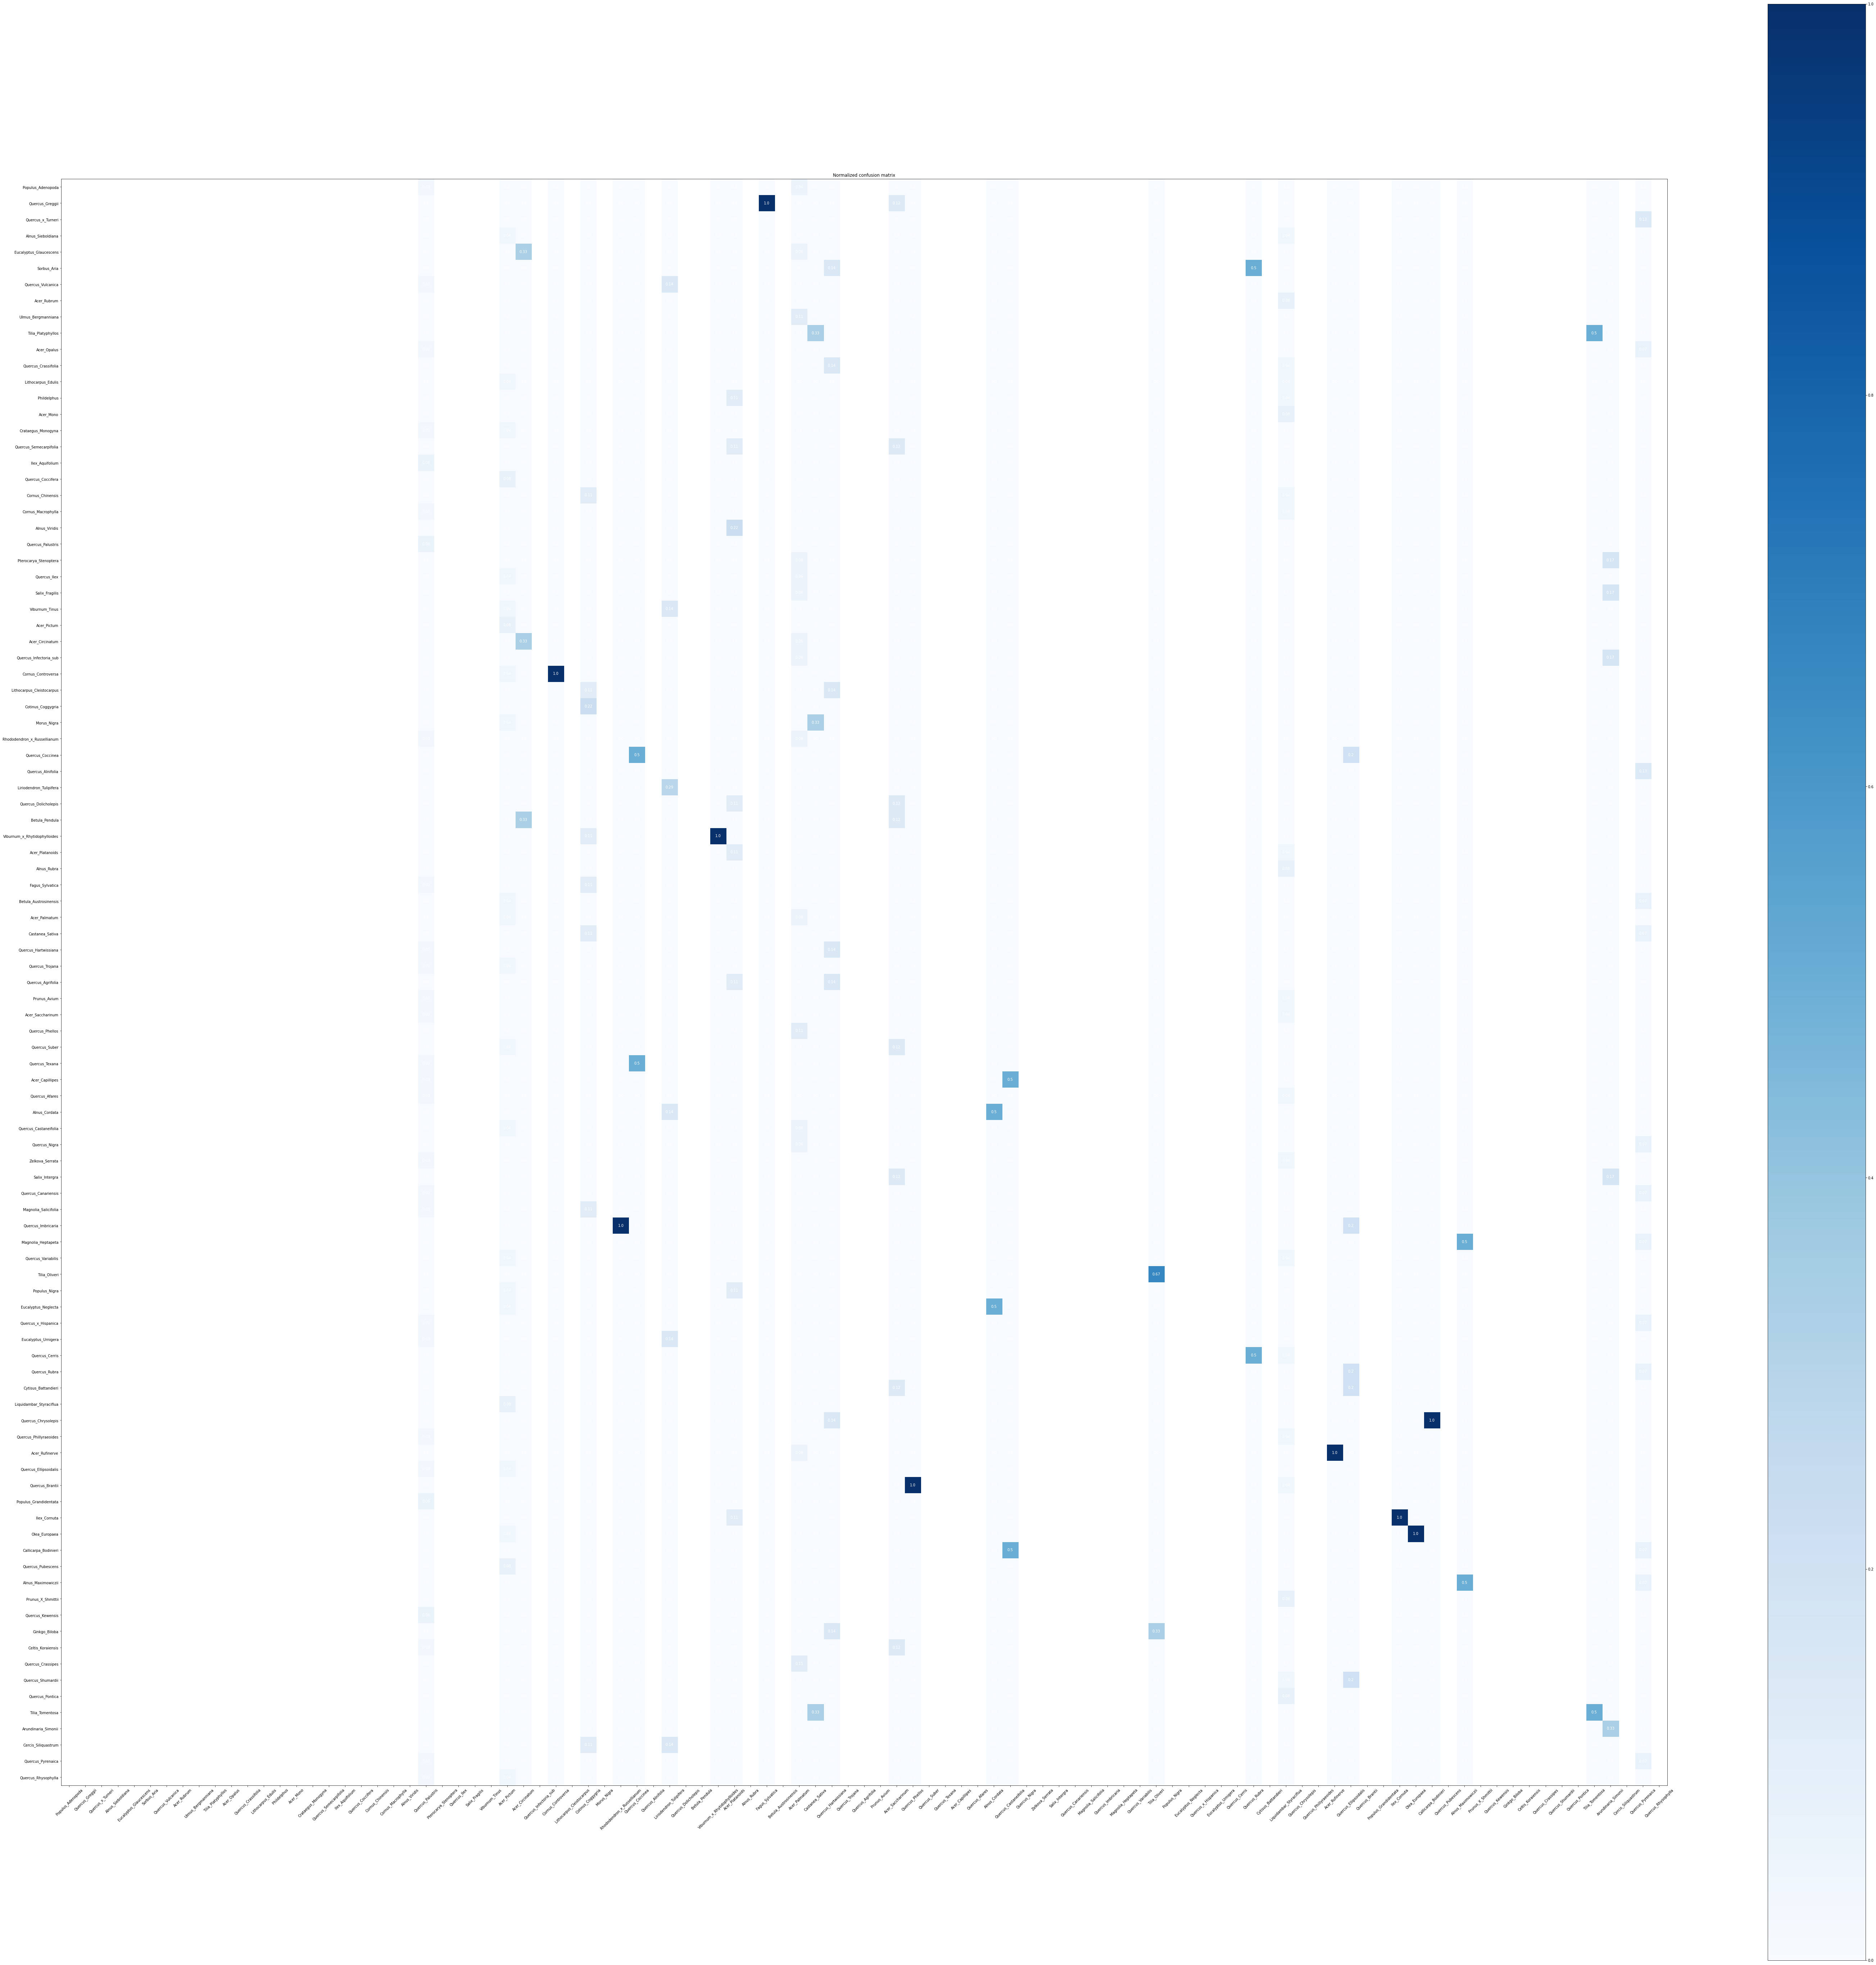

In [111]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_preds)
cm = cm/np.sum(cm,axis=0)
cmap = plt.cm.Blues
tick_marks = np.arange(num_classes)
fig, ax = plt.subplots(figsize=(100,100))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                       ha="center", va="center", color="w")
plt.title('Normalized confusion matrix')
fig.colorbar(im)
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects);

# Second model with Dropout

In [0]:
def get_conv_model_B(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(4,(3,3), activation="relu")(inputs) 
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(100, activation=tf.nn.relu)(layers)#change number of neurons of dense layer
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Dense(100, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='RMSprop',loss='categorical_crossentropy' ,metrics=['accuracy'] )
    return model

In [118]:
#instantiate the model
del model
num_classes = len( y_test_oh[1])
model1 = get_conv_model_B(num_classes,img_size=128)
model1.summary()

using 99 classes
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 126, 126, 4)       40        
_________________________________________________________________
batch_normalization_22 (Batc (None, 126, 126, 4)       16        
_________________________________________________________________
flatten_10 (Flatten)         (None, 63504)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               6350500   
_________________________________________________________________
batch_normalization_23 (Batc (None, 100)               400       
_________________________________________________________________
dense_24 (Dense)             (None, 100) 

In [0]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(X_train_ri.astype(np.float32), y_train_oh.astype(int), epochs=epochs, callbacks=[tensorboard], batch_size=batch_size, validation_data=( X_test_ri, y_test_oh))
    metrics = model.evaluate( X_test_ri.astype(np.float32), y_test_oh.astype(int))
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [124]:
train(model1, batch_size=8, epochs=20, model_name="model_B")

Epoch 1/20
99/99 [==============================] - 10s 104ms/step - loss: 4.2557 - accuracy: 0.0694 - val_loss: 4.3985 - val_accuracy: 0.0808
Epoch 2/20
99/99 [==============================] - 10s 102ms/step - loss: 3.0207 - accuracy: 0.3346 - val_loss: 4.5022 - val_accuracy: 0.0960
Epoch 3/20
99/99 [==============================] - 10s 101ms/step - loss: 1.9209 - accuracy: 0.6035 - val_loss: 4.8114 - val_accuracy: 0.0253
Epoch 4/20
99/99 [==============================] - 10s 102ms/step - loss: 1.2020 - accuracy: 0.7538 - val_loss: 4.7428 - val_accuracy: 0.0909
Epoch 5/20
99/99 [==============================] - 10s 102ms/step - loss: 0.7177 - accuracy: 0.8674 - val_loss: 4.4479 - val_accuracy: 0.1364
Epoch 6/20
99/99 [==============================] - 10s 102ms/step - loss: 0.4674 - accuracy: 0.9167 - val_loss: 3.6601 - val_accuracy: 0.1768
Epoch 7/20
99/99 [==============================] - 10s 101ms/step - loss: 0.3026 - accuracy: 0.9470 - val_loss: 4.2006 - val_accuracy: 0.2071

{'accuracy': 0.3636363744735718, 'loss': 3.8727469444274902}

## Acurracy second model

In [125]:
test_preds = model1.predict(X_test_ri).argmax(axis=1)
test_preds.shape, y_test
Accuracy = np.mean(test_preds == y_test)
print('Accuracy = ', Accuracy*100, '%')

Accuracy =  36.36363636363637 %


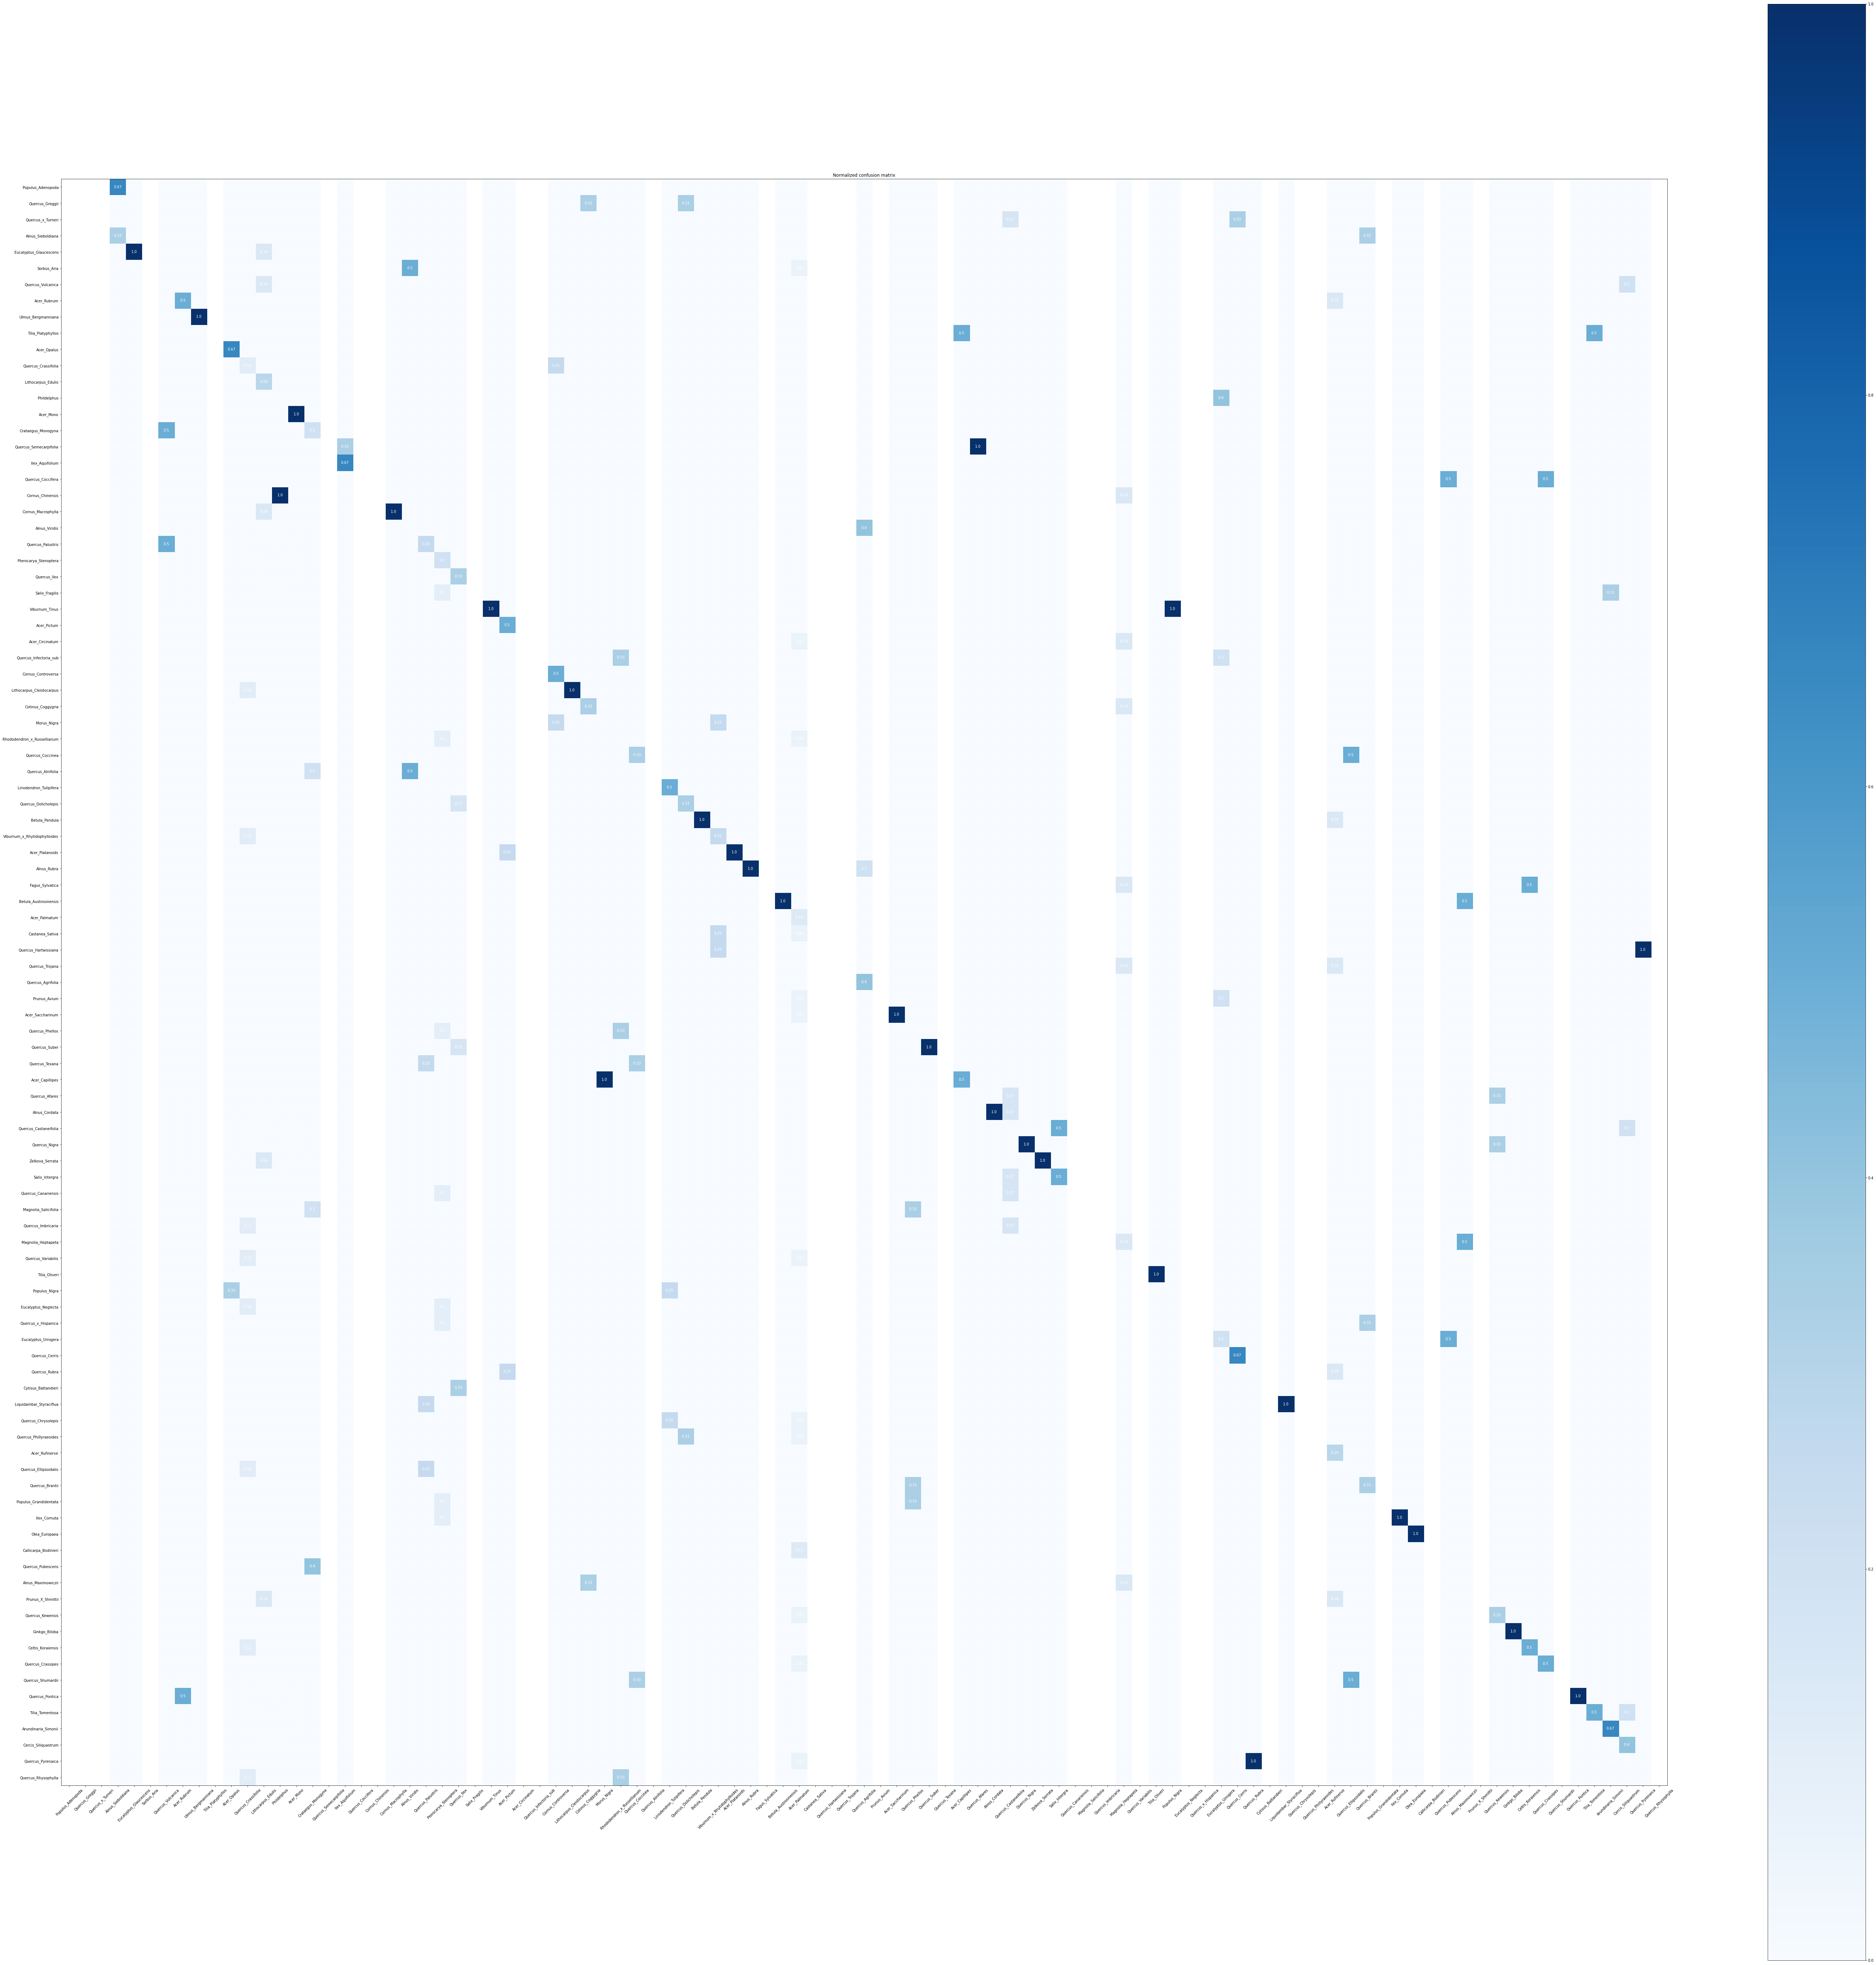

In [126]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_preds)
cm = cm/np.sum(cm,axis=0)
cmap = plt.cm.Blues
tick_marks = np.arange(num_classes)
fig, ax = plt.subplots(figsize=(100,100))
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                       ha="center", va="center", color="w")
plt.title('Normalized confusion matrix')
fig.colorbar(im)
plt.xticks(tick_marks, objects, rotation=45)
plt.yticks(tick_marks, objects);